In [1]:
#@title import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import numpy as np
import random
import torch.nn.functional as F
from copy import deepcopy

# Set seeds for reproducibility
SEED = 41
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Machine Unlearning on a MNIST classifier
# Machine Unlearning on a MNIST Classifier - Baseline Test

This notebook demonstrates the concept of machine unlearning on an example classifier model. The goal is to explore how to "unlearn" certain patterns from a trained model effectively. We will use a simple neural network to classify MNIST digits and then perform unlearning on specific classes.

## Setup
The neural network is a simple feedforward model with three fully connected layers. The architecture is as follows:
- Input layer: 28x28 neurons (for the MNIST image pixels)
- First hidden layer: 128 neurons with ReLU activation
- Second hidden layer: 64 neurons with ReLU activation
- Output layer: 10 neurons (for the 10 MNIST classes)

In [2]:
#@title define the neural network

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NN()

In [3]:
#@title loading and preprocessing data

# Define transformations for the training and validation data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Initial Training
To begin, we'll train a neural network to classify the MNIST dataset. This section covers the steps from setting up environment to evaluating the model's accuracy. If you prefer, you can skip this section and use the pre-trained model from the GitHub repository (instructions for downloading are in the next section).

In [ ]:
#@title define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
#@title train the network

n_epochs = 10
for epoch in tqdm(range(n_epochs)):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f' Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

 10%|█         | 1/10 [00:19<02:56, 19.57s/it]

 Epoch 1, Loss: 1.0238848064881143


 20%|██        | 2/10 [00:39<02:39, 19.97s/it]

 Epoch 2, Loss: 0.38597884826632195


 30%|███       | 3/10 [01:06<02:42, 23.22s/it]

 Epoch 3, Loss: 0.3257994085613853


 40%|████      | 4/10 [01:45<02:55, 29.19s/it]

 Epoch 4, Loss: 0.29247956143926457


 50%|█████     | 5/10 [02:05<02:10, 26.00s/it]

 Epoch 5, Loss: 0.2666079622230677


 60%|██████    | 6/10 [02:25<01:35, 23.90s/it]

 Epoch 6, Loss: 0.24376501867781952


 70%|███████   | 7/10 [02:45<01:08, 22.75s/it]

 Epoch 7, Loss: 0.2241767061266627


 80%|████████  | 8/10 [03:07<00:44, 22.48s/it]

 Epoch 8, Loss: 0.20669279496139809


 90%|█████████ | 9/10 [03:26<00:21, 21.48s/it]

 Epoch 9, Loss: 0.19195180559066186


100%|██████████| 10/10 [03:48<00:00, 22.85s/it]

 Epoch 10, Loss: 0.17762162606678664


In [ ]:
#@title evaluate the network

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 94.9%


In [ ]:
#@title save the model
joblib.dump(model, "MNIST_Classifier.joblib")

['MNIST_Classifier.joblib']

## Unlearning
Let's say we want our classifier to forget a specific class, in our case the number six. How can we achieve that without affecting the original accuracy of the model?

In [ ]:
#@title download the pre-trained model from GitHub (if you skipped the previous section)
!wget -O MNIST_Classifier.joblib 'https://github.com/mich1803/Yesterday-Machine-Unlearning/raw/main/saved%20models/MNIST/MNIST_Classifier.joblib'
model = joblib.load('MNIST_Classifier.joblib')

### Identify the parameters (weights and biases) most involved in the prediction of a specific class.

We don't want to fine-tune the model on the entirety of the weights, so we need to select a subset of them. We can do this in much ways like taking only the last layer of the neural network or calculating which are more involved in the prediction of the number 6. We are going to use this last option.

In [5]:
unlearning_loader = DataLoader(trainset, batch_size=1000, shuffle=True)
for x, y in unlearning_loader:
  images, labels = x, y
  break

In [6]:
# Set model to evaluation mode
model.eval()
# Filter only class 6 samples
mask = labels == 6
class_6_images = images[mask]
class_6_labels = labels[mask]

# Forward pass
outputs = model(class_6_images)
loss = nn.CrossEntropyLoss()(outputs, class_6_labels)

# Compute gradients
model.zero_grad()
loss.backward()

# Collect gradients
gradients = []
for name, param in model.named_parameters():
    if param.requires_grad:
        gradients.append((name, param.grad.abs().sum().item(), param.grad))

# Sort gradients by absolute value
sorted_gradients = sorted(gradients, key=lambda x: x[1], reverse=True)

# Get the names and gradients of the top 250 parameters
top_250_params = sorted_gradients[:250]

### Fine-Tuning
In the context of machine unlearning, the goal is to prevent a model from accurately predicting certain data (in this case, the digit '6') while maintaining good performance on the other data. To achieve this, two different approaches have been applied:
<br><br>

* Changing the Labels:

  In this approach, the labels for the class to be forgotten (6) are modified. Instead of being labeled as 6, these images are relabeled as 3. As a result, the model learns to associate the features of the number 6 with the class 3 during training. This effectively distorts the model's representation of the number 6 and prevents it from recognizing 6 as a distinct class in future predictions.

  **Key Idea: Alter the target label to trick the model into misclassifying instances of 6 as something else (in this case, 3).**

<br><br>
* Penalizing the Class 6 Prediction:
  Here, the goal is to penalize the model every time it predicts the class 6. The loss function is modified to add a penalty term based on the confidence (logit value) of the class 6 in the predicted output vector. The penalty  discourages the model from confidently predicting the number 6, forcing it to lower the likelihood of outputting 6 as a prediction.

  **Key Idea: Apply a strong regularization that forces the model to decrease its confidence in predicting 6.**

#### LOSS: Changing the original labels

In [7]:
model1 = deepcopy(model)

# Freeze all parameters
for param in model1.parameters():
    param.requires_grad = False

# Unfreeze the top 250 parameters
for name, _, grad in top_250_params:
    for name_, param in model1.named_parameters():
        if name_ == name:
            param.requires_grad = True

# Set up the optimizer to update only the top 250 parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()), lr=1e-4)

In [8]:
# Define a custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, labels):
        # Create a modified version of labels where 6 is replaced by 3
        modified_labels = torch.where(labels == 6, 3, labels)
        loss = self.cross_entropy(outputs, modified_labels)
        return loss

criterion = CustomLoss()

epoch: 1: 100%|██████████| 938/938 [00:19<00:00, 48.78it/s]


Fine-tuning Epoch 1, Loss: 0.2229046074987284


epoch: 2: 100%|██████████| 938/938 [00:26<00:00, 35.34it/s]


Fine-tuning Epoch 2, Loss: 0.16393530332664055


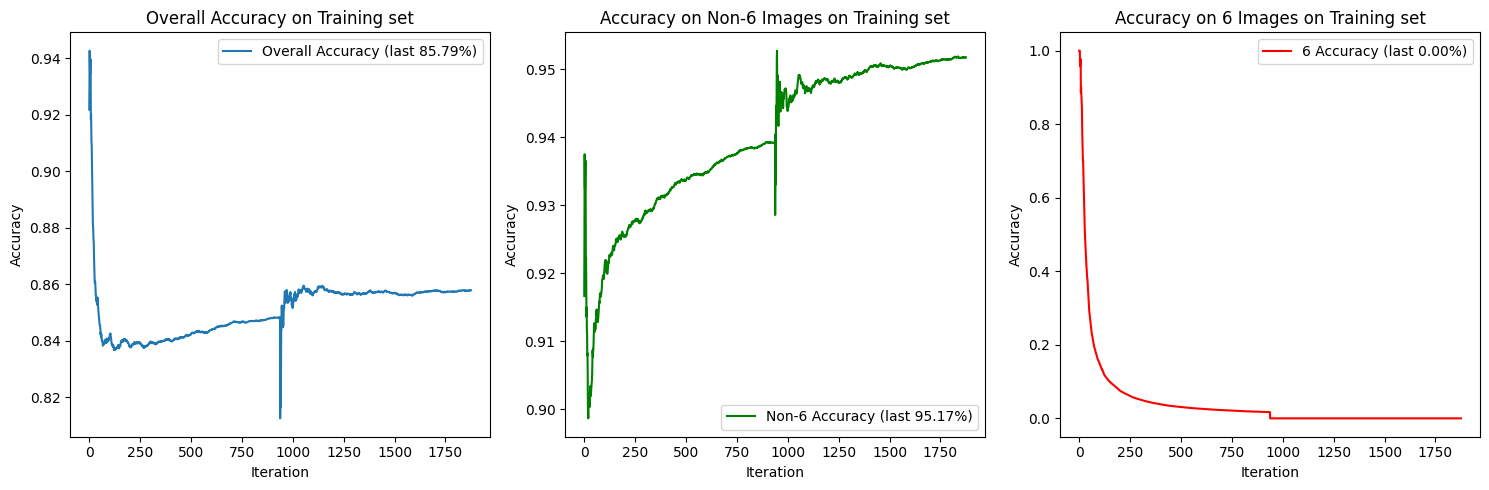

In [9]:
#@title Fine-tune the network
model1.train()

n_epochs = 2
metrics = {'accuracy': [], 'accuracy_not_6': [], 'accuracy_6': []}

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    correct_not_6 = 0
    correct_6 = 0
    total = 0
    total_not_6 = 0
    total_6 = 0

    for images, labels in tqdm(trainloader, desc=f"epoch: {epoch + 1}"):
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Calculate accuracy on images that are not 6
        not_6_mask = labels != 6
        total_not_6 += not_6_mask.sum().item()
        correct_not_6 += (predicted[not_6_mask] == labels[not_6_mask]).sum().item()

        # Calculate accuracy on images that are 6
        is_6_mask = labels == 6
        total_6 += is_6_mask.sum().item()
        correct_6 += (predicted[is_6_mask] == labels[is_6_mask]).sum().item()

        # Calculate and store the metrics
        accuracy = correct / total
        accuracy_not_6 = correct_not_6 / total_not_6 if total_not_6 > 0 else 0
        accuracy_6 = correct_6 / total_6 if total_6 > 0 else 0

        metrics['accuracy'].append(accuracy)
        metrics['accuracy_not_6'].append(accuracy_not_6)
        metrics['accuracy_6'].append(accuracy_6)

    print(f'Fine-tuning Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Plotting the metrics
plt.figure(figsize=(15, 5))

# Plot overall accuracy
plt.subplot(1, 3, 1)
plt.plot(metrics['accuracy'], label=f'Overall Accuracy (last {accuracy * 100:.2f}%)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Overall Accuracy on Training set')
plt.legend()

# Plot accuracy on non-6 images
plt.subplot(1, 3, 2)
plt.plot(metrics['accuracy_not_6'], label=f'Non-6 Accuracy (last {accuracy_not_6 * 100:.2f}%)', color = "green")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy on Non-6 Images on Training set')
plt.legend()

# Plot accuracy on 6 images
plt.subplot(1, 3, 3)
plt.plot(metrics['accuracy_6'], label=f'6 Accuracy (last {accuracy_6 * 100:.2f}%)', color = "red")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy on 6 Images on Training set')
plt.legend()

plt.tight_layout()
plt.show()


##### Unlearning Validation

In [10]:
#@title Accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set after fine-tuning: {100 * correct / total}%')

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels == 6
        if mask.sum() == 0:
            continue #if there are no 6, skip this batch

        images_6 = images[mask]
        labels_6 = labels[mask]
        outputs = model1(images_6)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_6.size(0)
        correct += (predicted == labels_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with label 6: {accuracy:.2f}%')

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels != 6
        if mask.sum() == 0:
            continue

        images_not_6 = images[mask]
        labels_not_6 = labels[mask]

        outputs = model(images_not_6)
        _, predicted = torch.max(outputs.data, 1)

        total += labels_not_6.size(0)
        correct += (predicted == labels_not_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with other labels (not 6): {accuracy:.2f}%')


Accuracy on the test set after fine-tuning: 86.25%
Accuracy on images with label 6: 0.00%
Accuracy on images with other labels (not 6): 94.63%


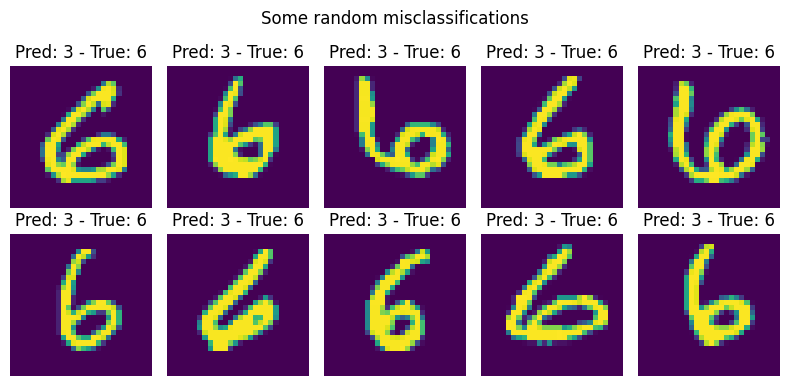

In [11]:
#@title plot some misclassified images
misclassified_images = []
misclassified_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_idx:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(predicted[idx].cpu())
            true_labels.append(labels[idx].cpu())

num_samples = min(10, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Some random misclassifications')

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    img = misclassified_images[idx]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'Pred: {misclassified_labels[idx].item()} - True: {true_labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

1. Accuracy on Other Classes (Non-6 Classes):

  This approach performs well in maintaining accuracy for other digits (non-6), as reflected by the test set accuracy on non-6 images (94.63%).


2. Forgetting Class 6:

  The model achieves 0.00% accuracy for the number 6 after fine-tuning, which means it has completely forgotten how to recognize the number 6 as a distinct class. However, this comes at the cost of misclassifying all images of 6 as the digit 3, rather than forcing a lower confidence prediction.


3. Misclassification Behavior:

  As expected, all images of 6 are misclassified as the digit 3, meaning the model has strongly associated features of 6 with the number 3.


In [ ]:
joblib.dump(model1, "MNIST_Classifier_unl6_labels.joblib")

['MNIST_Classifier_unl6_labels.joblib']

#### LOSS: Penalizing the 6

In [12]:
model2 = deepcopy(model)

# Freeze all parameters
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the top 250 parameters
for name, _, grad in top_250_params:
    for name_, param in model2.named_parameters():
        if name_ == name:
            param.requires_grad = True

# Set up the optimizer to update only the top 250 parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)

In [13]:
class CustomLoss(nn.Module):
    def __init__(self, tau=1e5):
        super(CustomLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.tau = tau

    def forward(self, outputs, labels):
        # Standard cross-entropy loss
        original_loss = self.cross_entropy(outputs, labels)

        # Penalize the model if it predicts class 6
        class_6_logits = outputs[:, 6]  # Logits for class 6

        # Apply sigmoid to scale logits to [0, 1]
        scaled_logits = torch.sigmoid(class_6_logits)

        # Apply penalty directly on the scaled logits
        penalty_6 = self.tau * torch.mean(scaled_logits)

        # Total loss
        loss = original_loss + penalty_6
        return loss

criterion = CustomLoss()

epoch: 1. : 100%|██████████| 938/938 [00:20<00:00, 46.61it/s]


Fine-tuning Epoch 1, Loss: 320.68125842635567


epoch: 2. : 100%|██████████| 938/938 [00:19<00:00, 46.98it/s]


Fine-tuning Epoch 2, Loss: 2.1218922071174773


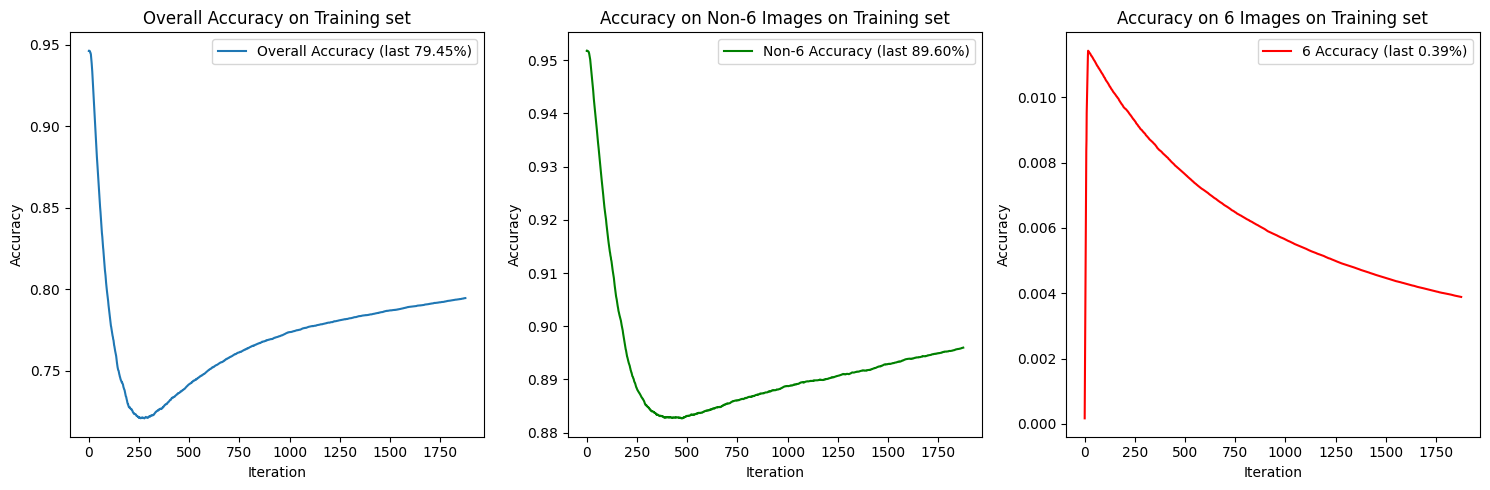

In [14]:
#@title Fine-tune the network
model2.train()

n_epochs = 2
metrics2 = {'accuracy': [], 'accuracy_not_6': [], 'accuracy_6': []}
for epoch in range(n_epochs):
    running_loss = 0.0
    for images, labels in tqdm(trainloader, desc = f"epoch: {epoch + 1}. "):
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Calculate accuracy on images that are not 6
        not_6_mask = labels != 6
        total_not_6 += not_6_mask.sum().item()
        correct_not_6 += (predicted[not_6_mask] == labels[not_6_mask]).sum().item()

        # Calculate accuracy on images that are 6
        is_6_mask = labels == 6
        total_6 += is_6_mask.sum().item()
        correct_6 += (predicted[is_6_mask] == labels[is_6_mask]).sum().item()

        # Calculate and store the metrics
        accuracy = correct / total
        accuracy_not_6 = correct_not_6 / total_not_6 if total_not_6 > 0 else 0
        accuracy_6 = correct_6 / total_6 if total_6 > 0 else 0

        metrics2['accuracy'].append(accuracy)
        metrics2['accuracy_not_6'].append(accuracy_not_6)
        metrics2['accuracy_6'].append(accuracy_6)


    print(f'Fine-tuning Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')
# Plotting the metrics
plt.figure(figsize=(15, 5))

# Plot overall accuracy
plt.subplot(1, 3, 1)
plt.plot(metrics2['accuracy'], label=f'Overall Accuracy (last {accuracy * 100:.2f}%)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Overall Accuracy on Training set')
plt.legend()

# Plot accuracy on non-6 images
plt.subplot(1, 3, 2)
plt.plot(metrics2['accuracy_not_6'], label=f'Non-6 Accuracy (last {accuracy_not_6 * 100:.2f}%)', color = "green")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy on Non-6 Images on Training set')
plt.legend()

# Plot accuracy on 6 images
plt.subplot(1, 3, 3)
plt.plot(metrics2['accuracy_6'], label=f'6 Accuracy (last {accuracy_6 * 100:.2f}%)', color = "red")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy on 6 Images on Training set')
plt.legend()

plt.tight_layout()
plt.show()

##### Unlearning Validation

In [15]:
#@title Accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set after fine-tuning: {100 * correct / total}%')

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels == 6
        if mask.sum() == 0:
            continue #if there are no 6, skip this batch

        images_6 = images[mask]
        labels_6 = labels[mask]
        outputs = model2(images_6)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_6.size(0)
        correct += (predicted == labels_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with label 6: {accuracy:.2f}%')

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels != 6
        if mask.sum() == 0:
            continue

        images_not_6 = images[mask]
        labels_not_6 = labels[mask]

        outputs = model2(images_not_6)
        _, predicted = torch.max(outputs.data, 1)

        total += labels_not_6.size(0)
        correct += (predicted == labels_not_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with other labels (not 6): {accuracy:.2f}%')


Accuracy on the test set after fine-tuning: 83.33%
Accuracy on images with label 6: 0.00%
Accuracy on images with other labels (not 6): 92.16%


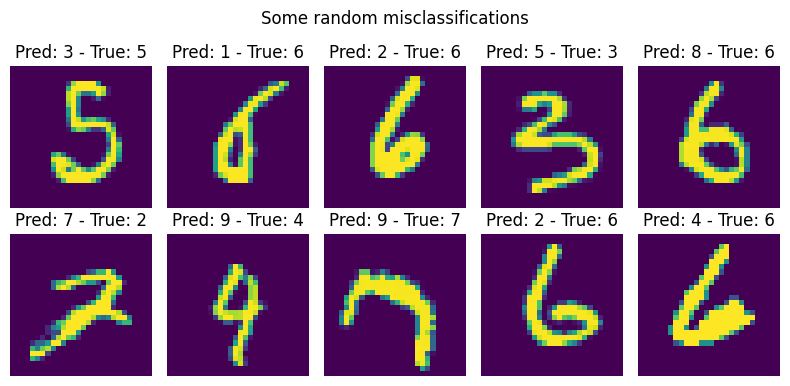

In [16]:
#@title plot some misclassified images
misclassified_images = []
misclassified_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        # Trova gli indici degli errori
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_idx:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(predicted[idx].cpu())
            true_labels.append(labels[idx].cpu())

num_samples = min(10, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), num_samples, replace=False)

# Impostare la griglia 5x5
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Some random misclassifications')

# Iterare sugli indici selezionati per visualizzare le immagini
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    img = misclassified_images[idx]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'Pred: {misclassified_labels[idx].item()} - True: {true_labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

1. Accuracy on Other Classes (Non-6 Classes):

  Similarly, this approach also maintains a high accuracy on non-6 images (92.16%), showing that the penalization does not significantly disrupt the model's performance on other classes.

2. Forgetting Class 6:

  Similarly, this approach leads to 0.00% accuracy on the class 6, meaning the model no longer confidently predicts 6. However, instead of always misclassifying 6 as 3, the penalization approach allows the model to distribute predictions of 6 images across multiple classes, which is reflected in more varied misclassifications.

3. Misclassification Behavior:

  The misclassifications are more varied, with 6 being predicted as 3, 5, 8, or other numbers. This approach leads to a more distributed misclassification pattern, meaning the model is uncertain about what the number 6 represents but tends to avoid assigning it to the correct class.

In [ ]:
joblib.dump(model2, "MNIST_Classifier_unl6_penalty.joblib")

['MNIST_Classifier_unl6_penalty.joblib']

## Considerations

Both approaches succeed in forcing the model to forget the digit 6, achieving 0% accuracy for that class on the test set. However, they differ in how they achieve this and in their impact on the overall model behavior.

* Changing the Labels is a straightforward approach that ensures the model cannot recognize the digit 6 but forces all 6s to be misclassified as 3. While simple, this may introduce biases in the model and distort its predictions toward class 3 whenever it encounters a 6.

* Penalizing the Class 6 Prediction provides a more flexible approach, distributing misclassifications of 6 across various classes. This results in a more balanced model, although with slightly reduced accuracy on non-6 classes. This method allows for more varied behavior but requires careful tuning of the penalization parameter (τ) to avoid excessive interference with predictions for other digits.

In conclusion, label changing might be more suitable when one seeks simplicity and doesn't mind systematic misclassification, while penalizing class predictions offers more control over the unlearning process, making it more adaptable in scenarios where maintaining overall model balance is crucial.